##### 데싸노트의 실전에서 통하는 머신러닝 (골든레빗 MUST HAVE 시리즈)
- XGBoost
- 부스팅 : 순차적으로 트리를 만들어 이전 트리로부터 더 나은 트리를 만드는 알고리즘
- XGBoost, LightGBM, CatBoost 등등
- XGBoost의 경우 손실함수와 모형 복잡도까지 같이 고려함
- 여담으로 케글에서 사랑받는 부스팅 모델


##### 그래서 뭐가 좋아요
- 예측 속도가 빠르고 예측력도 좋음
- 변수 종류가 많고 데이터가 클 수록 상대적으로 뛰어남


##### 이게 아쉬워요
- 복잡한 모델이라 해석에 어려움 있음
- 하이퍼파라미터 튜닝이 까다로움


##### 이럴 때 써먹어요
- 종속변수가 연속형이든 범주형이든 가리지 않음
- 이미지나 자연어가 아니라 표로 정리된 데이터라면 거의 모둔 상황에 사용 가능함


##### 오늘은 뭐해요
- 개인 취향에 따른 커플 성사가 잘 되는지 예측해보기

In [ ]:
# 교재에는 없는데 혹시라도 나올 수 있는 경고가 짜증나니 추가함
import warnings
warnings.filterwarnings('ignore')

In [1]:
# 데이터를 가져옵니다
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

file_url = 'https://media.githubusercontent.com/media/musthave-ML10/data_source/main/dating.csv'
data = pd.read_csv(file_url)

In [2]:
# 어떻게 생겼나 봅시다
data.head()

,has_null,gender,age,age_o,race,race_o,importance_same_race,importance_same_religion,pref_o_attractive,pref_o_sincere,...,funny_partner,ambition_partner,shared_interests_partner,interests_correlate,expected_happy_with_sd_people,expected_num_interested_in_me,like,guess_prob_liked,met,match
0,0,female,21.0,27.0,Asian/PacificIslander/Asian-American,European/Caucasian-American,2.0,4.0,35.0,20.0,...,7.0,6.0,5.0,0.14,3.0,2.0,7.0,6.0,0.0,0
1,0,female,21.0,22.0,Asian/PacificIslander/Asian-American,European/Caucasian-American,2.0,4.0,60.0,0.0,...,8.0,5.0,6.0,0.54,3.0,2.0,7.0,5.0,1.0,0
2,1,female,21.0,22.0,Asian/PacificIslander/Asian-American,Asian/PacificIslander/Asian-American,2.0,4.0,19.0,18.0,...,8.0,5.0,7.0,0.16,3.0,2.0,7.0,NaN,1.0,1
3,0,female,21.0,23.0,Asian/PacificIslander/Asian-American,European/Caucasian-American,2.0,4.0,30.0,5.0,...,7.0,6.0,8.0,0.61,3.0,2.0,7.0,6.0,0.0,1
4,0,female,21.0,24.0,Asian/PacificIslander/Asian-American,Latino/HispanicAmerican,2.0,4.0,30.0,10.0,...,7.0,6.0,6.0,0.21,3.0,2.0,6.0,6.0,0.0,1


In [3]:
# 중간에 잘린 거 다 보고 싶어요
pd.options.display.max_columns=40

# 이거로 한 번에 표시될 컬럼 수를 조절할 수 있습니다
# 당연히 rows도 가능해요

In [4]:
# 그건 그렇고 저 안에 뭐가 들은 거죠 진짜
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8378 entries, 0 to 8377
Data columns (total 39 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   has_null                       8378 non-null   int64  
 1   gender                         8378 non-null   object 
 2   age                            8283 non-null   float64
 3   age_o                          8274 non-null   float64
 4   race                           8315 non-null   object 
 5   race_o                         8305 non-null   object 
 6   importance_same_race           8299 non-null   float64
 7   importance_same_religion       8299 non-null   float64
 8   pref_o_attractive              8289 non-null   float64
 9   pref_o_sincere                 8289 non-null   float64
 10  pref_o_intelligence            8289 non-null   float64
 11  pref_o_funny                   8280 non-null   float64
 12  pref_o_ambitious               8271 non-null   f

- has_null : 변수 중에 null이 있는지 여부. 어떤 항목에 대한 무응답이 존재하는지의 여부로 보면 됨.
- age / age_o : 본인 나이 / 상대 나이
- race / race_o : 본인 인종 / 상대 인종
- importance_same_race / importance_same_religion : 인종과 종교를 중시하는가
- attractive(매력적), sincere(성실), intelligence(지적), funny(재미난), ambitious(야심찬), shared_interests(공통관심사)
- -> pref_o_xxx : 상대방이 xxx 항목을 얼마나 중요시 하는가
- -> xxx_o : 상대방이 본인에 대한 xxx 항목을 평가한 항목
- -> xxx_important : 본인이 xxx 항목에 대해 얼마나 중요시 하는가
- -> xxx_partner : 본인이 상대방에 대한 xxx 항목을 평가한 항목
- interests_correlate : 관심사 연관도 (취미 등)
- expected_happy_with_sd_people : 스피드 데이팅으로 만난 사람과 함께할 때 얼마나 좋은지
- expected_num_interested_in_me : 얼마나 많은 사람들이 나한테 관심보일지에 대한 기대치
- like : 파트너가 마음에 들었습니까?
- guess_prob_liked : 파트너가 나를 좋아하지 않을까요?
- met : 파트너를 스피드 데이팅 이벤트 이전에 만난 적이 있는지 여부 

In [5]:
# 통계적 정보 확인
round(data.describe(), 2)

,has_null,age,age_o,importance_same_race,importance_same_religion,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,attractive_o,sincere_o,intelligence_o,funny_o,ambitous_o,shared_interests_o,attractive_important,sincere_important,intellicence_important,funny_important,ambtition_important,shared_interests_important,attractive_partner,sincere_partner,intelligence_partner,funny_partner,ambition_partner,shared_interests_partner,interests_correlate,expected_happy_with_sd_people,expected_num_interested_in_me,like,guess_prob_liked,met,match
count,8378.00,8283.00,8274.00,8299.00,8299.00,8289.00,8289.00,8289.00,8280.00,8271.00,8249.00,8166.00,8091.00,8072.00,8018.00,7656.00,7302.00,8299.00,8299.00,8299.00,8289.00,8279.00,8257.00,8176.00,8101.00,8082.00,8028.00,7666.00,7311.00,8220.00,8277.00,1800.00,8138.00,8069.00,8003.00,8378.00
mean,0.87,26.36,26.36,3.78,3.65,22.50,17.40,20.27,17.46,10.69,11.85,6.19,7.18,7.37,6.40,6.78,5.47,22.51,17.40,20.27,17.46,10.68,11.85,6.19,7.18,7.37,6.40,6.78,5.47,0.20,5.53,5.57,6.13,5.21,0.05,0.16
std,0.33,3.57,3.56,2.85,2.81,12.57,7.04,6.78,6.09,6.13,6.36,1.95,1.74,1.55,1.95,1.79,2.16,12.59,7.05,6.78,6.09,6.12,6.36,1.95,1.74,1.55,1.95,1.79,2.16,0.30,1.73,4.76,1.84,2.13,0.28,0.37
min,0.00,18.00,18.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.83,1.00,0.00,0.00,0.00,0.00,0.00
25%,1.00,24.00,24.00,1.00,1.00,15.00,15.00,17.39,15.00,5.00,9.52,5.00,6.00,6.00,5.00,6.00,4.00,15.00,15.00,17.39,15.00,5.00,9.52,5.00,6.00,6.00,5.00,6.00,4.00,-0.02,5.00,2.00,5.00,4.00,0.00,0.00
50%,1.00,26.00,26.00,3.00,3.00,20.00,18.37,20.00,18.00,10.00,10.64,6.00,7.00,7.00,7.00,7.00,6.00,20.00,18.18,20.00,18.00,10.00,10.64,6.00,7.00,7.00,7.00,7.00,6.00,0.21,6.00,4.00,6.00,5.00,0.00,0.00
75%,1.00,28.00,28.00,6.00,6.00,25.00,20.00,23.81,20.00,15.00,16.00,8.00,8.00,8.00,8.00,8.00,7.00,25.00,20.00,23.81,20.00,15.00,16.00,8.00,8.00,8.00,8.00,8.00,7.00,0.43,7.00,8.00,7.00,7.00,0.00,0.00
max,1.00,55.00,55.00,10.00,10.00,100.00,60.00,50.00,50.00,53.00,30.00,10.50,10.00,10.00,11.00,10.00,10.00,100.00,60.00,50.00,50.00,53.00,30.00,10.00,10.00,10.00,10.00,10.00,10.00,0.91,10.00,20.00,10.00,10.00,8.00,1.00


- 자세히 보면 파트너를 평가하는 항목들은 max가 10인데
- 성격같은 중요도는 max가 100이나 60, 50 등 제각각인 상태임
- 이런 경우 데이터가 무슨 기준으로 수집됐는지를 알아야 도움이 됩니다.


- 교재 설명을 더 가져오면
- 평가 관련 변수는 0~10점을 각각의 항목에 넣습니다
- 근데 pref_o_funny, pref_o_ambitious, pref_o_shared_interests, attractive_o, sincere_o, intelligence_o 등 중요도 변수는 합쳐서 100점인 상태
- 그러니까 상대방이 각 항목에 대한 중요도 변수들의 합은 100이 되어야 한다는 것

In [7]:
# 일단 결측치나 봅시다
data.isna().mean()

has_null                         0.000000
gender                           0.000000
age                              0.011339
age_o                            0.012413
race                             0.007520
race_o                           0.008713
importance_same_race             0.009429
importance_same_religion         0.009429
pref_o_attractive                0.010623
pref_o_sincere                   0.010623
pref_o_intelligence              0.010623
pref_o_funny                     0.011697
pref_o_ambitious                 0.012772
pref_o_shared_interests          0.015397
attractive_o                     0.025304
sincere_o                        0.034256
intelligence_o                   0.036524
funny_o                          0.042970
ambitous_o                       0.086178
shared_interests_o               0.128432
attractive_important             0.009429
sincere_important                0.009429
intellicence_important           0.009429
funny_important                  0

- 그냥 결측치가 여기저기 넘쳐나는 상태인데 다행인 건 대체로 5% 미만임
- 그건 그렇고 XGBoost는 어쨌든 트리 베이스라 결측치를 채워야하는 게 까다로워요
- 윈저라이징을 하긴 할 건데 중요도와 관련된 변수들은 결측치를 없앨겁니다
- 나중에 중요도 x 점수로 계산할 일이 있어서 버릴겁니다

In [9]:
data = data.dropna(subset=['pref_o_attractive', 'pref_o_sincere', 'pref_o_intelligence', 'pref_o_funny', 'pref_o_ambitious', 'pref_o_shared_interests', 'attractive_important',
'sincere_important', 'intellicence_important', 'funny_important', 'ambtition_important', 'shared_interests_important'])

In [10]:
# 나머지는 -99로 채울겁니다
# '알 수 없음'이라는 의미로 받아주세요

data = data.fillna(-99)

In [11]:
# 우선 나이 차부터 시작해볼까요
# 근데 결측치를 -99로 채운 거 있어서 막 계산하면 안 됩니다

def age_gap(x):
    if x['age'] == -99:
        return -99
    elif x['age_o'] == -99:
        return -99
    elif x['gender'] == 'feamle':
        return x['age_o'] - x['age']
    else:
        return x['age'] - x['age_o']

# -99가 있으면 -99를 리턴하고
# 남자가 연상일 때 양수, 여자가 연상일 때 음수가 리턴되는 구조

In [12]:
# 나이차를 적용시켜봅시다
data['age_gap'] = data.apply(age_gap, axis=1)

In [13]:
# 근데 나이가 차이나는 그 자체를 중요하게 생각할 수도 있잖아요?
# 그래서 절댓값으로 나이차만 저장하는 컬럼 하나 더 만들겁니다

data['age_gap_abs'] = abs(data['age_gap'])

In [14]:
# 인종 관련 함수
# 마찬가지로 결측치 있으면 -99, 둘이 맞으면 1, 아니면 -1

def same_race(x):
    if x['race'] == -99:
        return -99
    elif x['race_o'] == -99:
        return -99
    elif x['race'] == x['race_o']:
        return 1
    else:
        return -1

In [15]:
# 적용해볼까요
data['same_race'] = data.apply(same_race, axis=1)

In [18]:
# 근데 importance_same_race 라는 컬럼도 있음
# 인종이 같으면 양수, 아니면 음수를 리턴할건데 숫자가 클 수록 당연히 중요도가 높을 것임
def same_race_point(x):
    if x['same_race'] == -99:
        return -99
    else:
        return x['same_race'] * x['importance_same_race']

In [19]:
# 이거도 적용해봅시다
data['same_race_point'] = data.apply(same_race_point, axis=1)

- 근데 왜 인종이 다르면 음수를 리턴할까
- 인종 신경 안 쓰는 사람은 'same_race'에 0을 갖고 있을텐데
- 만약 인종이 다르다는 걸 0으로 리턴해버리면 인종 신경 안 쓰는 사람이랑 구별하기 어려울 것입니다..

In [20]:
# 이제 평가하는 함수

def rating(data, importance, score):
    if data[importance] == -99:
        return -99
    elif data[score] == -99:
        return -99
    else:
        return data[importance] * data[score]

In [21]:
# 음... importance에 들어갈 컬럼들을 따로 만들면 좋을 거 같은데

data.columns[8:14]

Index(['pref_o_attractive', 'pref_o_sincere', 'pref_o_intelligence',
       'pref_o_funny', 'pref_o_ambitious', 'pref_o_shared_interests'],
      dtype='object')

In [22]:
# 저런 식으로 몇몇 컬럼들을 묶어봅시다

partner_imp = data.columns[8:14] # 상대방의 중요도
partner_rate_me = data.columns[14:20] # 상대방이 본인을 평가
my_imp = data.columns[20:26] # 나의 중요도
my_rate_partner = data.columns[26:32] # 상대방에 대한 본인의 평가

In [23]:
# 상대방 관련 새 변수 이름을 저장하는 리스트
new_label_partner = ['attractive_p', 'sincere_partner_p', 'intelligence_p', 'funny_p', 'ambition_p', 'shared_interests_p']

# 나와 관련된 새 변수 이름을 저장하는 리스트
new_label_me = ['attractive_m', 'sincere_partner_m', 'intelligence_m', 'funny_m', 'ambition_m', 'shared_interests_m']

In [24]:
# 이제 rating 함수를 이용해 중요도 점수를 계산해봅시다

for i, j, k in zip(new_label_partner, partner_imp, partner_rate_me):
    data[i] = data.apply(lambda x: rating(x, j, k), axis=1)


for i, j, k in zip(new_label_me, my_imp, my_rate_partner):
    data[i] = data.apply(lambda x: rating(x, j, k), axis=1)

In [25]:
# 마지막으로 더미를 만들어주면 끝 (One-Hot Encoding)

data = pd.get_dummies(data, columns=['gender', 'race', 'race_o'], drop_first=True)

In [26]:
data.head()

,has_null,age,age_o,importance_same_race,importance_same_religion,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,attractive_o,sincere_o,intelligence_o,funny_o,ambitous_o,shared_interests_o,attractive_important,sincere_important,intellicence_important,...,sincere_partner_p,intelligence_p,funny_p,ambition_p,shared_interests_p,attractive_m,sincere_partner_m,intelligence_m,funny_m,ambition_m,shared_interests_m,gender_male,race_Black/AfricanAmerican,race_European/Caucasian-American,race_Latino/HispanicAmerican,race_Other,race_o_Black/AfricanAmerican,race_o_European/Caucasian-American,race_o_Latino/HispanicAmerican,race_o_Other
0,0,21.0,27.0,2.0,4.0,35.0,20.0,20.0,20.0,0.0,5.0,6.0,8.0,8.0,8.0,8.0,6.0,15.0,20.0,20.0,...,160.0,160.0,160.0,0.0,30.0,90.0,180.0,140.0,105.0,90.0,75.0,0,0,0,0,0,0,1,0,0
1,0,21.0,22.0,2.0,4.0,60.0,0.0,0.0,40.0,0.0,0.0,7.0,8.0,10.0,7.0,7.0,5.0,15.0,20.0,20.0,...,0.0,0.0,280.0,0.0,0.0,105.0,160.0,140.0,120.0,75.0,90.0,0,0,0,0,0,0,1,0,0
2,1,21.0,22.0,2.0,4.0,19.0,18.0,19.0,18.0,14.0,12.0,10.0,10.0,10.0,10.0,10.0,10.0,15.0,20.0,20.0,...,180.0,190.0,180.0,140.0,120.0,75.0,160.0,180.0,120.0,75.0,105.0,0,0,0,0,0,0,0,0,0
3,0,21.0,23.0,2.0,4.0,30.0,5.0,15.0,40.0,5.0,5.0,7.0,8.0,9.0,8.0,9.0,8.0,15.0,20.0,20.0,...,40.0,135.0,320.0,45.0,40.0,105.0,120.0,160.0,105.0,90.0,120.0,0,0,0,0,0,0,1,0,0
4,0,21.0,24.0,2.0,4.0,30.0,10.0,20.0,10.0,10.0,20.0,8.0,7.0,9.0,6.0,9.0,7.0,15.0,20.0,20.0,...,70.0,180.0,60.0,90.0,140.0,75.0,120.0,140.0,105.0,90.0,90.0,0,0,0,0,0,0,0,1,0


In [27]:
# 이제 트레이닝 시작함

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop('match', axis=1), data['match'], test_size=0.2, random_state=100)

In [30]:
# XGBoost
# 하이퍼파라미터를 3개만 지정했는데 공식문서 보면 알겠지만..... 겁나 많음

import xgboost as xgb

model = xgb.XGBClassifier(n_estimators=500, max_depth=5, random_state=100)
model.fit(X_train, y_train)
pred = model.predict(X_test)

In [31]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

accuracy_score(y_test, pred)

0.8628536285362853

In [33]:
# 높아 보이는데 과연?
data['match'].describe()

count    8130.000000
mean        0.164822
std         0.371042
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: match, dtype: float64

- match 평균이 16% 수준인데 86% 정확도가 나왔다고?
- 이러면 나머지 84%는 매칭도 안 됐다는 얘기인데 뭐냐 이건

In [34]:
# 혼동행렬 까봅니다

print(confusion_matrix(y_test, pred))

[[1293   72]
 [ 151  110]]


- 1종 오류가 72건, 2종 오류가 151건

In [35]:
# classification_report를 사용하면 혼동 행렬 정보 파악이 쉬워짐

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92      1365
           1       0.60      0.42      0.50       261

    accuracy                           0.86      1626
   macro avg       0.75      0.68      0.71      1626
weighted avg       0.85      0.86      0.85      1626



- 웬만해서는 예측하고자 하는 값을 '1'로 설정할테니 '1'을 중점적으로 봅시다
- 아무리 봐도 점수들이... 많이 낮은데?
- 정밀도(precision) : 1로 예측한 것 중 얼마만큼 실제로 1인가 (TP/TP+FP) --- 1종 오류랑 관련 있음
- 재현율(recall) : 실제 1 중 얼마나 1로 예측했는가 (TP/TP+FN) --- 2종 오류랑 관련 있음
- F1-Score : 정밀도와 재현율의 조화평균(주어진 수들의 역수의 산술평균의 역수) -> 2 * precision * recall / precision + recall
- 만약 1종 오류가 중요하다면 정밀도를 2종 오류가 중요하다면 재현율을 신경써야함
- 특별히 뭐가 더 중요하지 않다라고 생각된다면 F1-Score로 판단하는게 무난함

#### 경사하강법
- 머신러닝이 학습할 때 최소의 오차를 찾도록 만드는 방법
- 오차 함수에 대한 경사도(미분계수)를 기준으로 매개변수를 반복적으로 이동해 최소 오차를 찾음
- 문제가 미분계수를 0으로 할만한 곳이 2개 이상이 되면.. 그러니까 지역 최솟값이랑 전역 최솟값이 같이 튀어나올 수도 있는데
- 만약 학습률이 충분하지 않다면 지역 최솟값을 전역 최솟값으로 오해해서 원하는 값이 안 나올 수 있어요
- 근데 이거 어떻게 찾죠 사람이 일일히 찾나?
- 그러라고 gridSearch가 있습니다

In [36]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'learning_rate' : [0.01, 0.1, 0.3], # 매개변수를 얼만큼 이동하면서 찾을까요
    'max_depth' : [5, 7, 10], # 트리의 깊이
    'subsample' : [0.5, 0.7, 1], # 모델을 학습할 때 일부 데이터만 써서 트리를 만듬. 0.5인 경우 데이터의 절반씩 랜덤 추출함. 오버피팅 방지도 좋음.
    'n_estimators' : [300, 500, 1000] # 전체 나무의 개수
}

In [37]:
# 이번에는 GridSearch를 이용해 갑니다

model = xgb.XGBClassifier()
gs_model = GridSearchCV(model, parameters, n_jobs=1, scoring='f1', cv=5)

# n_jobs : 사용할 코어 수
# scoring : 어떤 기준으로 할까요
# cv : k-fold value


gs_model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             n_jobs=1,
             param_grid={'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [5, 7, 10],
                         'n_estimators': [300, 500, 1000],
                         'subsample': [0.5, 0.7, 1]},
             scoring='f1')

In [38]:
# 과연 우리의 최적 하이퍼 파라미터는 뭘까요

gs_model.best_params_

{'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 1000, 'subsample': 0.7}

In [39]:
# gs_model은 GridSearchCV가 완료된 상태라 최적 하이퍼 파라미터가 들어가있음
pred = gs_model.predict(X_test)

In [40]:
accuracy_score(y_test, pred)

0.8646986469864698

In [41]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92      1365
           1       0.61      0.44      0.51       261

    accuracy                           0.86      1626
   macro avg       0.75      0.69      0.72      1626
weighted avg       0.85      0.86      0.86      1626



- 이런다고 살림살이 나아지진 않지만 그래도 뭐.... 개선이 되긴 됐네

In [42]:
# 근데 아깐 자동이었으니까 이번엔 수동으로 최적 하이퍼 파라미터를 넣어봅시다


model = xgb.XGBClassifier(learning_rate = 0.3, max_depth=5, n_estimators=1000, subsample=0.7, random_state=100)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.3, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=100,
              reg_alpha=0, reg_lambda=1, ...)

In [43]:
# 피처의 중요도를 보는데 이러면 뭐가 뭔지 모르잖아
model.feature_importances_

array([0.01150109, 0.01082742, 0.01022119, 0.00718562, 0.00875766,
       0.0123986 , 0.00954044, 0.01321438, 0.0093683 , 0.01306725,
       0.01172539, 0.04970133, 0.01383632, 0.01136932, 0.03743635,
       0.01084364, 0.02035189, 0.01262651, 0.01013969, 0.01491023,
       0.00823365, 0.01112775, 0.01111076, 0.02414486, 0.01220307,
       0.00887889, 0.02382516, 0.01218321, 0.01428757, 0.01086993,
       0.01052965, 0.01879149, 0.07235699, 0.02200928, 0.0256325 ,
       0.00951941, 0.01001255, 0.00818915, 0.01228332, 0.0102939 ,
       0.01075684, 0.01275628, 0.01316534, 0.00996484, 0.01135542,
       0.01015693, 0.00892564, 0.00885974, 0.00880156, 0.00861083,
       0.00977737, 0.01543015, 0.03114583, 0.01392106, 0.02247188,
       0.03680198, 0.04524185, 0.0137238 , 0.04118284, 0.03144409],
      dtype=float32)

In [44]:
# 데이터프레임으로 만들어서 보면 되겠다

feature_imp = pd.DataFrame({'features':X_train.columns, 'values':model.feature_importances_})
feature_imp.head()

,features,values
0,has_null,0.011501
1,age,0.010827
2,age_o,0.010221
3,importance_same_race,0.007186
4,importance_same_religion,0.008758


<AxesSubplot:xlabel='values', ylabel='features'>

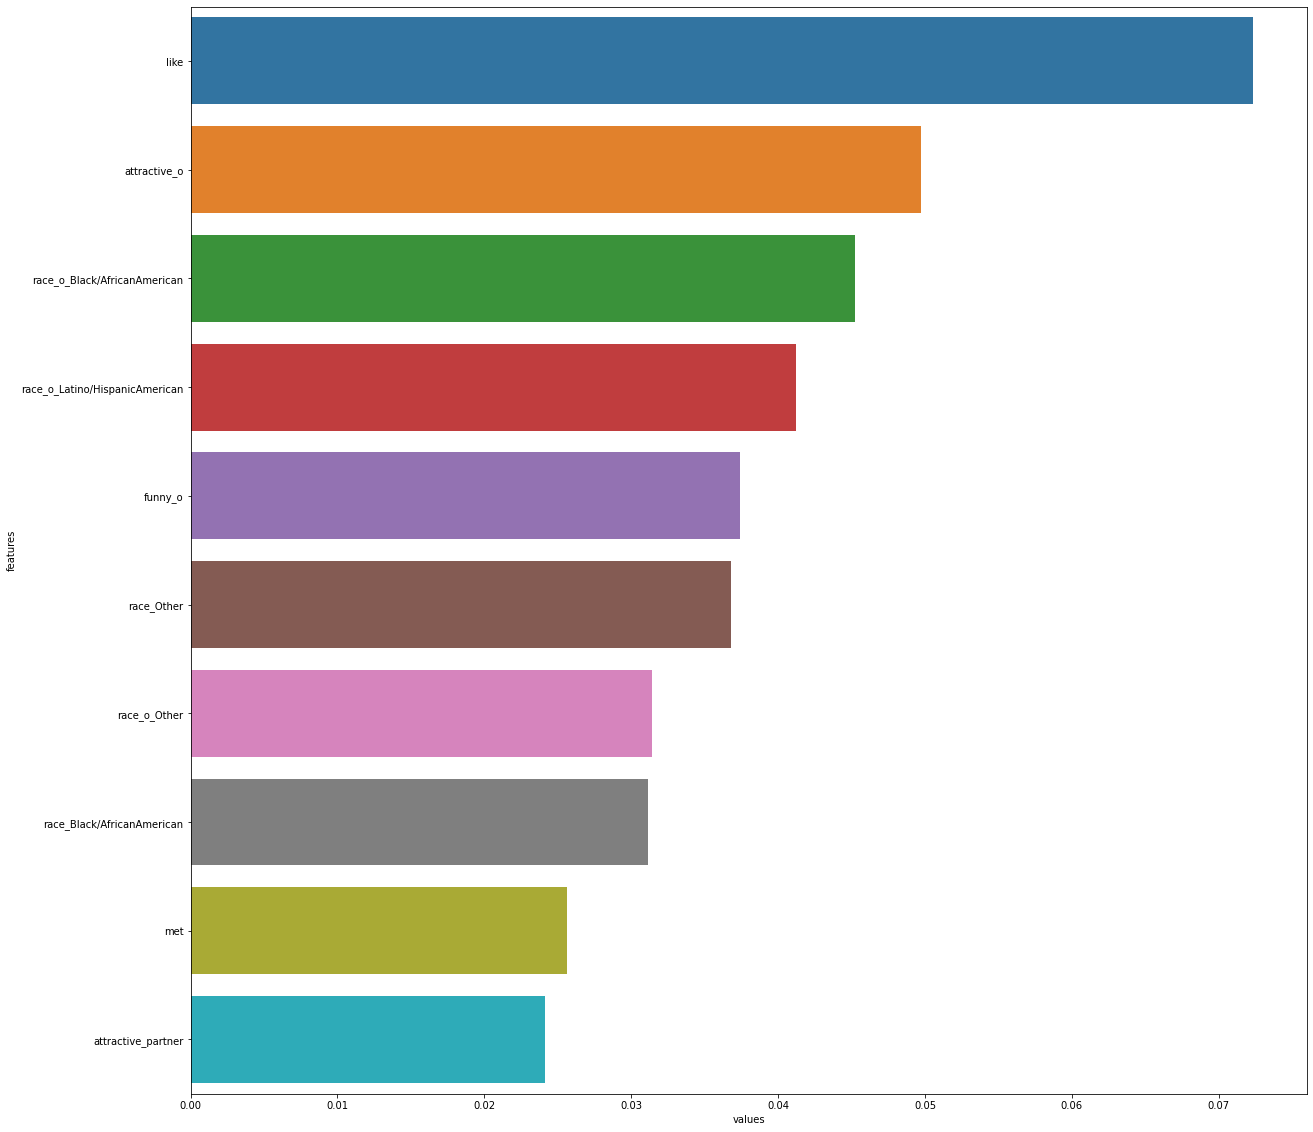

In [45]:
# 내림차순으로 그래프를 뽑아봅시다

plt.figure(figsize=(20,20))
sns.barplot(x='values', y='features', data=feature_imp.sort_values(by='values', ascending=False).head(10))

## 보충

#### 트리 모델은 어떻게 진화했는가
결정트리 > 배깅 > 랜덤포레스트 > 부스팅 > 경사 부스팅 > XG 부스팅


##### 배깅
- 부트스트랩 훈련셋을 사용하는 트리모델
- 부트스트랩 : 데이터 일부분을 무작위로 반복 추출하는 방법
- 이렇게 여러번 뽑아 여러 부분 집합을 쓰면 오버피팅을 방지함

##### 랜덤포레스트
- 배깅을 발전시킨 모델
- 데이터와 변수 일부를 사용해 여러 트리를 만듦

##### 부스팅
- 랜덤 포레스트에서 발전함
- 랜덤 포레스트는 트리가 독립적인데 부스팅은 그렇지 않다는 게 차이점
- 부스팅의 경우에는 트리를 만들 때 이전 트리의 정보를 이용해 만듦

##### 에이다부스트(AdaBoost)
- 단계적으로 트리를 만들 때 이전 단계의 분류 결과에 따라 가중치를 부여하거나 수정함
- 이전 트리에서 잘못 분류된 데이터한테 높은 가중치, 후속 트리에서 가중치가 높은 데이터를 분류하는데 우선 순위를 둔다

##### 경사부스팅
- 부스팅에 경사하강법을 접목시킨 방법
- 이전 모델의 에러를 기반으로 다음 트리를 만들어감
- 여기 해당하는 게 XGBoost, LightGBM, CatBoost 등

##### XGBoost
- 경사부스팅에 계산 성능 최적화와 알고리즘 개선을 꾀함
- 병렬화, 분산 컴퓨팅, 캐시 최적화 등을 활용하여 계산 속도를 개선했음
- 2차 도함수(2번 미분)를 활용해 더 적절한 이동방향과 이동크기를 찾아내 빠른 시간에 전역 최솟값에 도달하도록 함
- 정규화 파라미터 모델 지원하는 것도 장점. LASSO(L1), Ridge(L2) 정규화 하이퍼 파라미터를 지원함. (오버피팅 방지)


##### 나아가기
- 그리드 서치 수행할 때 다른 하이퍼파라미터 값을 넣어 더 나은 예측을 보일 수 있는 조합이 있는지 찾아봅시다